# Machine Translation with Transformer
Machine translation is a key milestone in the development of Natural Language Processing (NLP). The Transformer model, introduced by Vaswani et al. (2017), was a major revolution because it replaced RNN and CNN-based architectures with a more efficient attention mechanism.

In this notebook, we will build a Transformer model from scratch to automatically translate from English to Indonesian. This approach does not use a pre-trained model, but instead implements the core components of the Transformer, from positional coding, multi-head awareness, encoder-decoder layers, to the training process.

The main focus is not only on the translation results, but also on the implementation capabilities and understanding of the Transformer's internal mechanisms. This is relevant because the Transformer is the foundation of various modern models such as BERT, GPT, and ChatGPT, so mastering its basic architecture is essential for both Machine Learning Engineers and Data Scientists.

Dataset source: www.manythings.org/anki

## Sequence-to-sequence learning

### Import Library

In [ ]:
import os
import re
import pathlib
import random
import string
import zipfile
import numpy as np
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Bidirectional,GRU,LSTM,Embedding
from tensorflow.keras.layers import Dense,MultiHeadAttention,LayerNormalization,Embedding,Dropout,Layer
from tensorflow.keras import Sequential,Input
from tensorflow.keras.callbacks import ModelCheckpoint

### Download and Extract Dataset

#### Download ZIP (no auto-extract)

In [ ]:
#path_to_zip = keras.utils.get_file(
#    "ind-eng.zip",
#    origin="http://storage.googleapis.com/download.tensorflow.org/data/ind-eng.zip",
#    extract=False)

#### Manual extraction

In [ ]:
#with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
#    zip_ref.extractall(pathlib.Path(path_to_zip).parent)

#text_file = pathlib.Path(path_to_zip).parent / "ind-eng" / "ind.txt"

#### View all extracted files

In [ ]:
text_file = "ind.txt"

with open(text_file, encoding="utf-8") as f:
    lines = f.read().split("\n")[:-1]

### Prepare Text Pairs

Each line contains an English sentence and a corresponding Indonesian sentence. The English sentence is the source sequence, and the Indonesian sentence is the target sequence. We add a "[start]" token at the front and an "[end]" token at the end of the Indonesian sentence.

In [ ]:
# Start and end indicate when the translation of the word/phrase starts and stops.

text_pairs = []
for line in lines:
    parts = line.split("\t")
    if len(parts) >= 2:  # make sure there are at least 2 columns
        english = parts[0]
        indonesian = parts[1]
        indonesian = "[start] " + indonesian + " [end]"
        text_pairs.append((english, indonesian))

In [ ]:
print("Number of pairs:", len(text_pairs))
print("Example text:", text_pairs[2900])

Number of pairs: 14881
Example text: ('Can it be repaired?', '[start] Bisakah diperbaiki? [end]')


Printing random text pairs English - Indonesian

In [ ]:
import random
print(random.choice(text_pairs))

('I forgot to close the door.', '[start] Aku lupa menutup pintunya. [end]')


### Split Data

- train_pairs: initial 70% of the data
- val_pairs: next 15%
- test_pairs: last 15%
- 70% training: large enough to learn patterns.
- 15% validation: sufficient for hyperparameter tuning.
- 15% test: sufficient to measure the model's generalization performance.

#### Determine the amount of validation data 15% of the total data

In [ ]:
random.shuffle(text_pairs)

num_val_samples = int(0.15 * len(text_pairs))

#### Taking the remaining data for training, after setting aside 15% for validation and 15% for testing.

In [ ]:
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

In [ ]:
print("Number of train data:", len(train_pairs))
print("Number of validation data:", len(val_pairs))
print("Number of test data:", len(test_pairs))

Number of train data: 10417
Number of validation data: 2232
Number of test data: 2232


### Preprocessing dan Vectorization

* string.punctuation is a Python built-in that contains all common punctuation characters
* Creates a list of all characters that are considered "punctuation that you want to remove or clean from the text".

In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, f"[{re.escape(string.punctuation)}¿]", "")

In [ ]:
vocab_size = 15000

This means that only the 15,000 most frequently occurring words will be used in the dictionary (vocab). Next, determine the maximum length of the token sequence after the text is tokenized.

In [ ]:
sequence_length = 20

* Vectorizes input (English)
* Used for encoders, which only need plain text sequences (without special tokens like [start] / [end]).

In [ ]:
source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

* Vectorizes the target (Indonesian)
* output_sequence_length=20: Since the target has [start] and [end] tokens, the target is 1 token longer than the input.
* standardize=custom_standardization: Uses a custom text cleaning function (e.g., removes certain punctuation but retains [start] and [end]).

In [ ]:
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

#### Extract all English sentences from training data pairs.

In [ ]:
train_english_texts = [pair[0] for pair in train_pairs]

#### Extract all Indonesian sentences (with [start] and [end])

In [ ]:
train_indonesian_texts = [pair[1] for pair in train_pairs]

#### Train the TextVectorization layer to build a vocabulary based on the training text.
`.adapt()` is essential for vectorization to recognize common words and efficiently construct the vocabulary.

In [ ]:
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_indonesian_texts)

### Dataset Format

In [ ]:
batch_size = 64

Meaning: The model will process 64 sentence pairs (English–Indonesian) in one step.

In [ ]:
def format_dataset(eng, ind):
    eng = source_vectorization(eng) # Input tokenization (English)
    ind = target_vectorization(ind) # Target tokenization (Indonesian)
    return ({"english": eng, "indonesian": ind[:, :-1]}, ind[:, 1:])
    # All target tokens EXCEPT the last or EXCEPT the first

def make_dataset(pairs):
    # Split the (eng, ind) pair into 2 lists
    eng_texts, ind_texts = zip(*pairs)

    # Create a tf.data.Dataset from text pairs
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(ind_texts)))
    dataset = dataset.batch(batch_size) # Split data into batches of size 64
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE) # Batch content format with dataset format
    return dataset.shuffle(2048).prefetch(tf.data.AUTOTUNE).cache() # Store the transformed data in memory for efficiency.

In [ ]:
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
train_ds

<CacheDataset element_spec=({'english': TensorSpec(shape=(None, 20), dtype=tf.int64, name=None), 'indonesian': TensorSpec(shape=(None, 20), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 20), dtype=tf.int64, name=None))>

In [ ]:
val_ds

<CacheDataset element_spec=({'english': TensorSpec(shape=(None, 20), dtype=tf.int64, name=None), 'indonesian': TensorSpec(shape=(None, 20), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 20), dtype=tf.int64, name=None))>

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"english {inputs['english']},\n\n\n inputs['english'].shape: {inputs['english'].shape}")
    print(f"indonesian {inputs['indonesian']},\n\n\n inputs['indonesian'].shape: {inputs['indonesian'].shape}")
    print(f"targets {targets}, \n\n\n targets.shape: {targets.shape}")

english [[  86    8 1113 ...    0    0    0]
 [   2   17   33 ...    0    0    0]
 [   2   15    6 ...    0    0    0]
 ...
 [  23   20    5 ...    0    0    0]
 [  20    5 2448 ...    0    0    0]
 [   2  323   95 ...    0    0    0]],


 inputs['english'].shape: (64, 20)
indonesian [[  2 816  36 ...   0   0   0]
 [  2   5   6 ...   0   0   0]
 [  2   5  33 ...   0   0   0]
 ...
 [  2  14   7 ...   0   0   0]
 [  2  10 173 ...   0   0   0]
 [  2   9 340 ...   0   0   0]],


 inputs['indonesian'].shape: (64, 20)
targets [[ 816   36  519 ...    0    0    0]
 [   5    6   61 ...    0    0    0]
 [   5   33  329 ...    0    0    0]
 ...
 [  14    7   41 ...    0    0    0]
 [  10  173 2307 ...    0    0    0]
 [   9  340   42 ...    0    0    0]], 


 targets.shape: (64, 20)


## Sequence-to-sequence learning with Transformer

### Positional Embedding
This layer combines word/token embeddings with positional embeddings so that the transformer model can understand the order of words in a sentence. Positional Embedding ensures that the transformer knows not only what words are present, but also their order in the sentence. Without this component, the transformer would simply see words as an unordered "bag of words."

In [ ]:
class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)

        #Translates ID tokens (numbers) into a vector of dimension output_dim.
        self.token_embeddings = Embedding(
            input_dim=input_dim, output_dim=output_dim, mask_zero=True  # enable auto masking!
        )

      # intermediate = self.getPositionEncoding(seq_len=input_dim,d=vocab_size,n=output_dim)
      # Positions 0, 1, 2, ..., sequence_length-1 are embedded like regular tokens.
      # Difference: The input here is a sequence of positions, not word IDs.

        self.position_embeddings = Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        # Use fixed length of self.sequence_length
        positions = tf.range(start=0, limit=tf.shape(inputs)[-1], delta=1)
        positions = self.position_embeddings(positions) # (1, sequence_length)
        x = self.token_embeddings(inputs)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
        })
        return config

### Transformer Encoder
The TransformerEncoder is the encoder block of the transformer architecture, which captures the relationships between words in a sentence using self-attention and a feed-forward network.

`TransformerEncoder = Self-Attention + Feed-Forward + Residual + Normalization`

Its function is to build a contextual representation of words → each word does not stand alone, but understands its relationship to other words in the sentence.

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super().__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        attention_output = self.attention(inputs, inputs, attention_mask=None)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

### Transformer Decoder
The `TransformerDecoder` is responsible for generating an output sequence based on the representation provided by the encoder, while ensuring that the generation process is autoregressive (only looking at the previous token).

In short, the decoder combines two aspects:
* Autoregressive generation (only looking at the past through masked self-attention).
* The global context of the input (through cross-attention to the encoder).

In [ ]:
class TransformerDecoder(layers.Layer):
    # A constructor containing multihead plus masked self attention
    def __init__(self, embed_dim, dense_dim, num_heads):
        super().__init__()

        #Masked self-attention: only looking at the previous token, so as not to “peek into the future”.
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        #Cross-attention: connects the output of the encoder to the decoder (input from the source language).
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        #Feedforward network: 2 Dense layers as non-linear processing.
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])

        #Normalization at each stage (after residual connection).
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        #Creates a lower triangular mask (causal mask) of size [batch, seq_len, seq_len]
        #Prevents position i from looking at token j > i.
        #Used to prevent the decoder model from learning the next token (future blindness) during training.
    def get_causal_attention_mask(self, inputs):
        i = tf.range(tf.shape(inputs)[1])[:, tf.newaxis]
        j = tf.range(tf.shape(inputs)[1])
        mask = tf.cast(i >= j, dtype="int32")
        return tf.reshape(mask, (1, tf.shape(inputs)[1], tf.shape(inputs)[1]))

    def call(self, inputs, encoder_outputs, mask=None):

        #Make a mask for self-attention, so as not to “peek ahead”.
        causal_mask = self.get_causal_attention_mask(inputs)

        #Masked Self-Attention
        #Focus only on the previous or current token. Add residual + layernorm
        attention_output_1 = self.attention_1(inputs, inputs, attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)

        #Cross Attention (Decoder attends to Encoder)
        #Connecting the target representation with the representation
        #generated by the encoder (e.g., from an English sentence).
        attention_output_2 = self.attention_2(attention_output_1, encoder_outputs, encoder_outputs)
        attention_output_2 = self.layernorm_2(attention_output_1 + attention_output_2)

        #FFN strengthens the token representation. Then, residual connection and layer normalization are performed.
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

### Build a Transformer Model

#### Determines the size of the representation vector for each token.

In [ ]:
embed_dim = 256

#### Determines the size of the hidden layer in the FFN block in the encoder and decoder

In [ ]:
dense_dim = 2048

#### Determines the size of the number of parallel attention heads in the attention layer.

In [ ]:
num_heads = 8

#### Defines the input for the source language (English) in the form of a sequence of ID tokens, with dynamic length (None).

In [ ]:
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")

#### English token representation that takes into account word order/position.

In [ ]:
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

#### Full context representation for the entire input sentence (English).

In [ ]:
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

#### Input in the form of an ID token for the target language (Indonesian), used during training.

In [ ]:
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="indonesian")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

In [ ]:
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
transformer.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ english             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ indonesian          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,845,120 │ english[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,845,120 │ indonesian[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 256) │  3,155,456 │ positional_embed… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decoder │ (None, None, 256) │  5,259,520 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, None, 256) │          0 │ transformer_deco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None,      │  3,855,000 │ dropout_3[0][0]   │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,960,216 (76.14 MB)

 Trainable params: 19,960,216 (76.14 MB)

 Non-trainable params: 0 (0.00 B)

#### Model Interpretation
1. Input Layer
  * english (InputLayer) → (None, None)
  Input English text sequence (sequence length is flexible).
  * indonesian (InputLayer) → (None, None)
  Input Indonesian text sequence (target sequence).
2. Positional Embedding
  * positional_embedding (english) → (None, None, 256) | 3,845,120 parameters
  * positional_embedding (spanish) → (None, None, 256) | 3,845,120 parameters
  * Each token (both input and target) is converted into a 256-dimensional embedding vector, then positional information is added so the model knows the word order.
  * Parameter = vocab_size * embedding_dim (here approximately 15k * 256 = 3.8 million).
3. Transformer Encoder
  * transformer_encoder → (None, None, 256) | 3,155,456 parameters
  * Accepts an English embedding input and processes it through:
    - Multi-Head Self-Attention (relationships between words in English sentences).
    - Feedforward Network (dense projection) for nonlinear transformation.
    - Residual + Normalization for stability
  * Output is a contextual representation of English.
4. Transformer Decoder
  * transformer_decoder → (None, None, 256) | 5,259,520 parameters
  * Accepts:
    - Target sequence embedding (Indonesian)
    - Encoder representation (English)
  * Processing includes:
    - Masked Self-Attention (only allows the previous token to be seen in Indonesian).
    - Cross-Attention (connects Indonesian tokens with the English encoder representation).
    - Feedforward Network.
  * The output is a representation of the target token that already knows the context of the previous input + output.
5. Dropout
  * dropout_3 → (None, None, 256)
  Regularization layer to prevent overfitting.
6. Dense (Output Layer)
  * dense_4 (Dense) → (None, None, 15000) | 3,855,000 parameters
  * A linear layer that maps the 256-dimensionality to the target vocabulary size (15k).
  * Each target token is projected onto a word probability distribution via softmax.
7. Total Parameters
  * Total parameters = ~20 million (76 MB)
  * All trainable (no frozen parameters).
8. Core Architecture
  * This model is a seq2seq Transformer for machine translation (English → Spanish) with:
    - 256-dimensional embedding
    - Encoder + Decoder stack
    - Target vocabulary size 15k
    - 20 million parameters in total

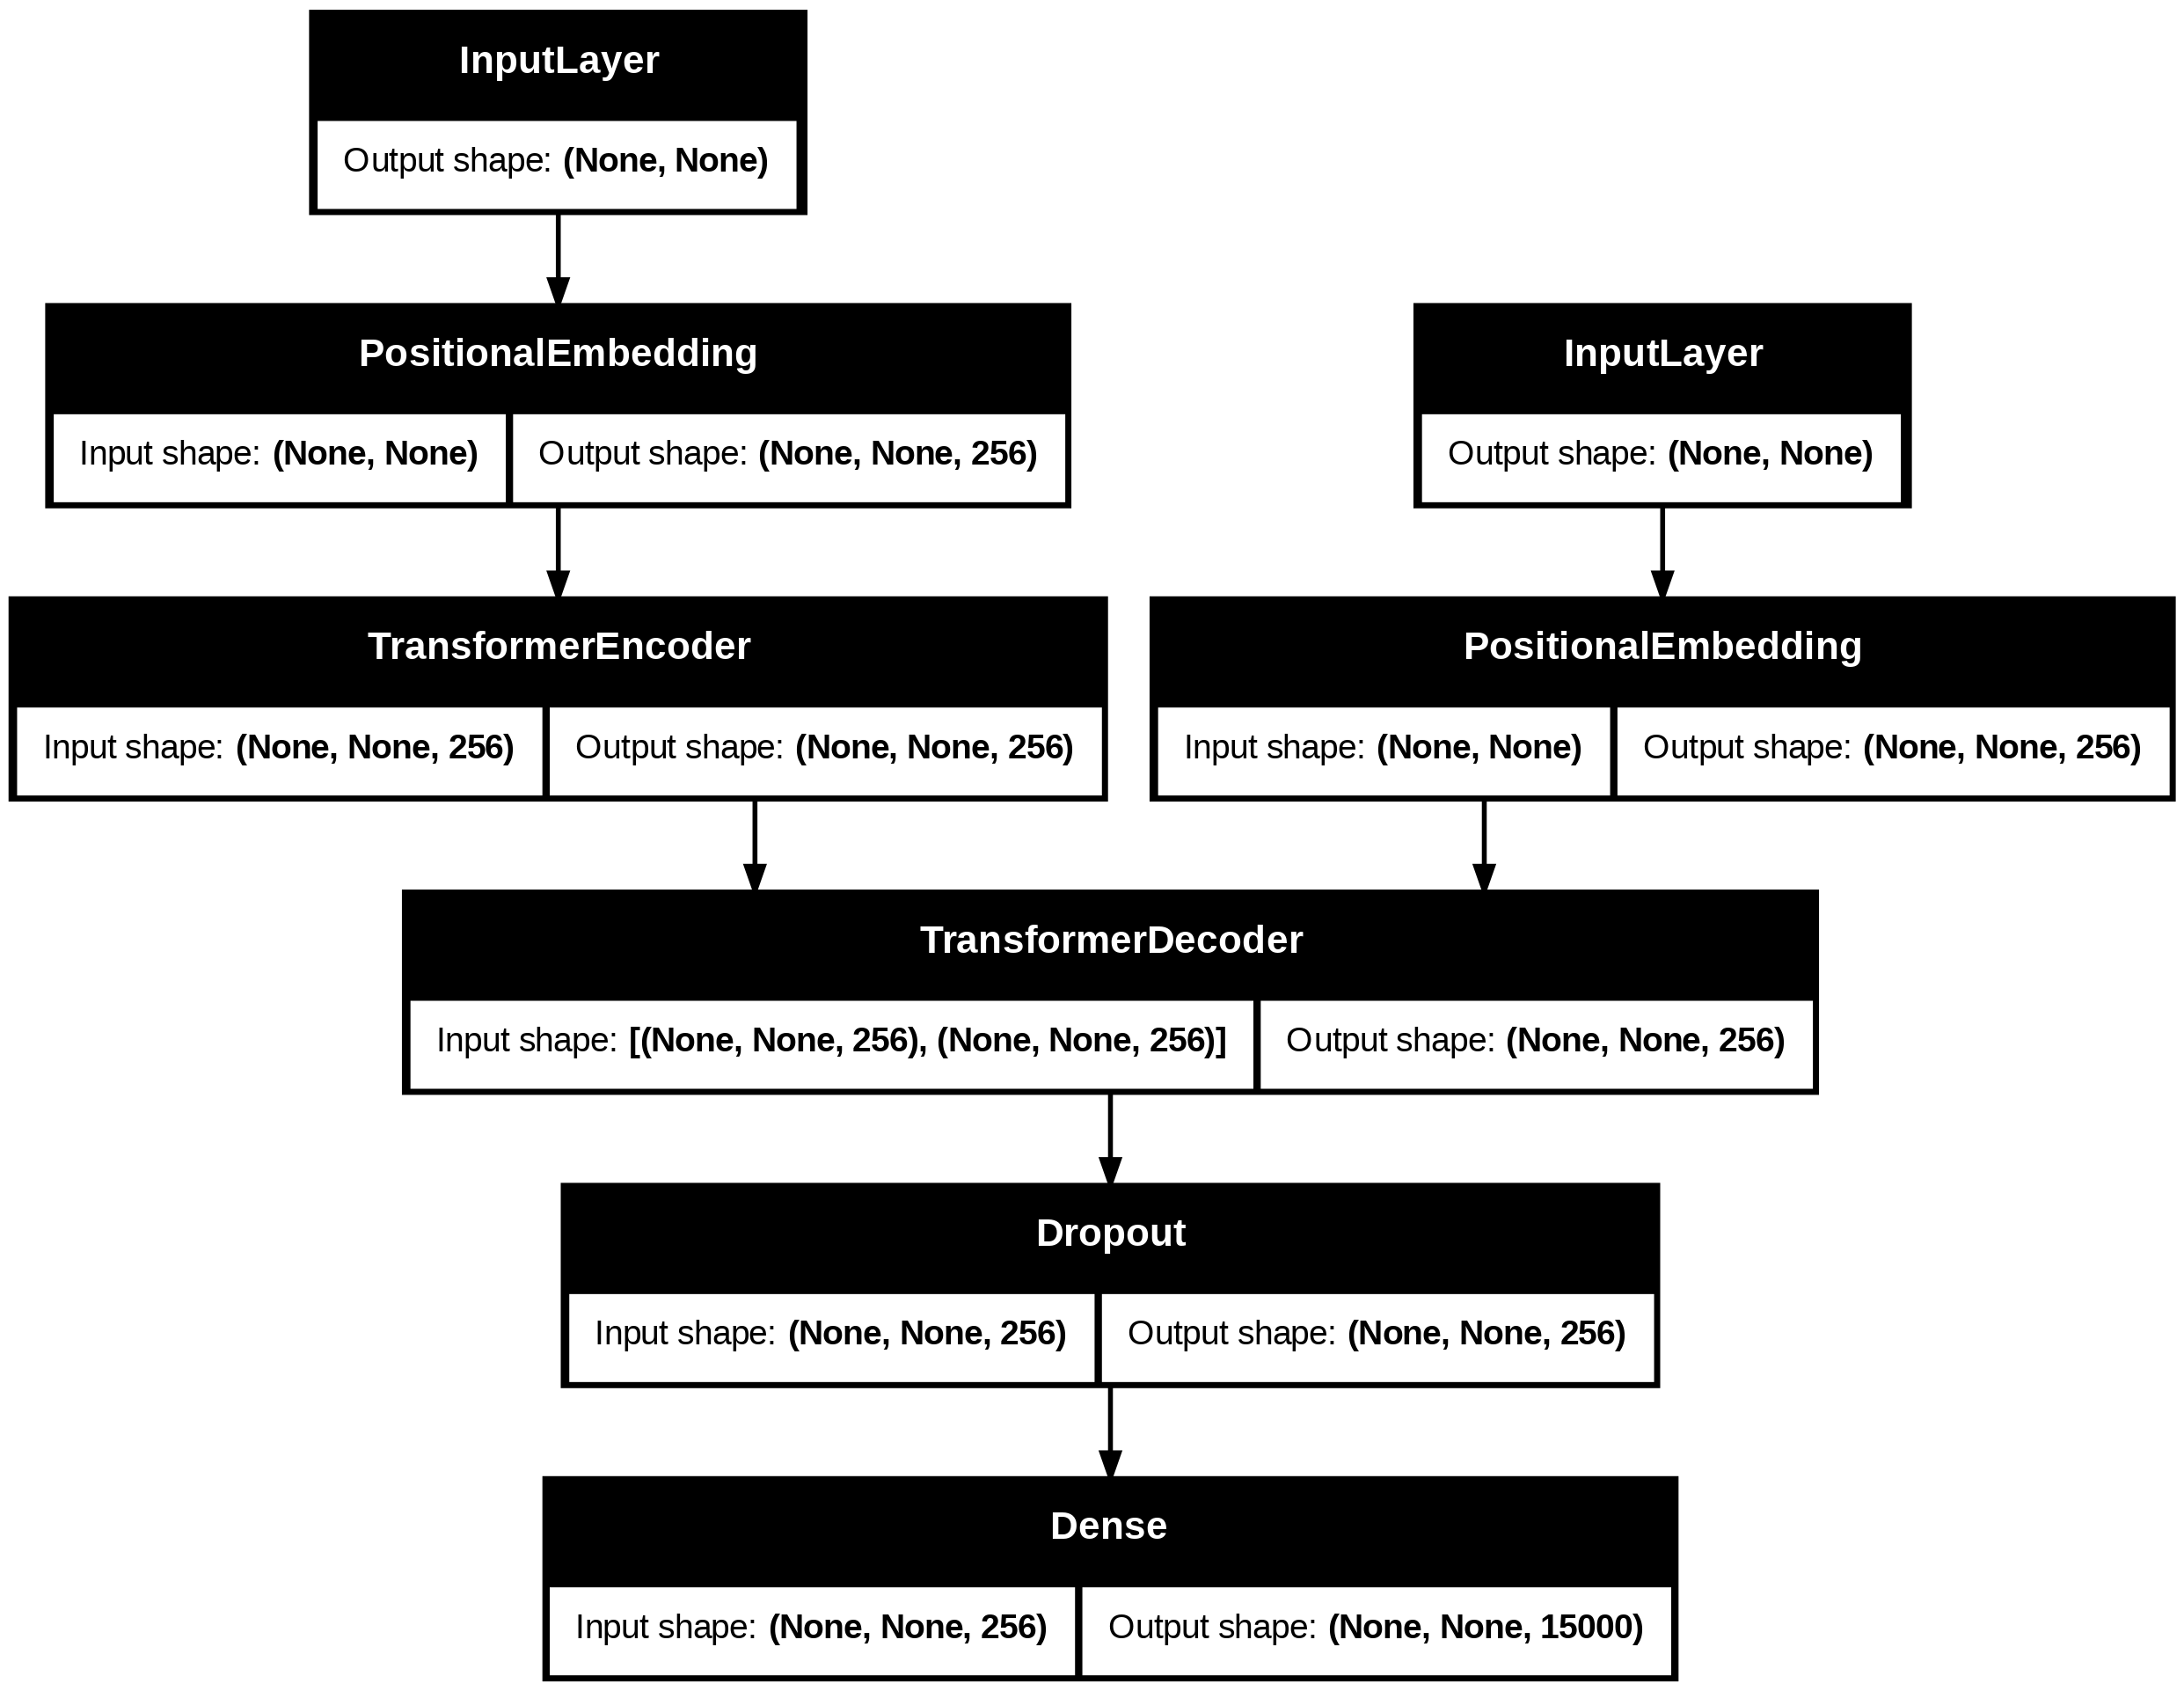

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(transformer, to_file='transformer.png', show_shapes=True)
Image(filename='transformer.png')

The lighter setting (faster training) will be named vanguard and the initial setting will be named transformer

## Build a Vanguard Model

### Determine the initial configuration

In [ ]:
embed_dim = 128
dense_dim = 512
num_heads = 4
sequence_length = 20
batch_size = 32

### Defines the input for the source language (English) in the form of a sequence of ID tokens, with dynamic length (None).

In [ ]:
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")

### English token representation that takes into account word order/position.

In [ ]:
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

### Full context representation for the entire input sentence (English).

In [ ]:
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

### Input in the form of an ID token for the target language (Indonesian), used during training.

In [ ]:
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="indonesian")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

In [ ]:
vanguard = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
vanguard.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ english             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ indonesian          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 128) │  1,922,560 │ english[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 128) │  1,922,560 │ indonesian[0][0]  │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    396,032 │ positional_embed… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 128) │    660,096 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, None, 128) │          0 │ transformer_deco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, None,      │  1,935,000 │ dropout_7[0][0]   │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,836,248 (26.08 MB)

 Trainable params: 6,836,248 (26.08 MB)

 Non-trainable params: 0 (0.00 B)

### Model Interpretation
1. Input Layer
  * english (InputLayer): accepts input in the form of English sequence tokens.
  * indonesian (InputLayer): accepts input in the form of Indonesian sequence tokens.
  * Both are in the form (None, None) → meaning the sequence length is flexible, and the batch size is also flexible.
2. Positional Embedding
  * english → positional_embedding:
    - Token embedding + positional embedding, resulting in a 128-dimensional representation.
    - Number of parameters: 1,922,560
    - → This is derived from the vocabulary size (input_dim) × output_dim (128).
  * indonesian → positional_embedding_1:
    - Same as above, for Indonesian.
    - The parameters are also 1,922,560.
    - These two embeddings ensure that both English and Indonesian tokens have a vector representation + positional information in the sequence.
3. Transformer Encoder
  * Input: English embedding.
  * Process: self-attention + feedforward network + residual + norm layer.
  * Output: 128-dimensional English contextual representation.
  * Parameters: 396,032 (quite light because embed_dim is only 128 and the number of heads is limited).
4. Transformer Decoder
  * Main input: Indonesian embedding.
  * Additional input: the result of the encoder (English).
  * Process: masked self-attention for the decoder, cross-attention to the encoder output, then feedforward network.
  * Output: Indonesian representation connected to the English context.
  * Parameters: 660,096 (larger than the encoder, due to additional cross-attention).
5. Dropout
  * dropout_7: maintains generalization, prevents overfitting.
6. Dense Output Layer
  * dense_9 (Dense, 15,000 units):
  * Output is a probability distribution over 15,000 words (assuming target vocabulary size = 15k).
  * Parameters: 1,935,000 (128 × 15,000 + bias).
7. Total Parameters
  * 6,836,248 (~6.8M parameters)
  * Very lightweight compared to standard Transformer models (for example, the original Transformer can have hundreds of millions of parameters).
  * It's reasonable to call it "vanguard" because it's compact and easy to train with limited resources.
8. Concise Interpretation
  * This vanguard model is a seq2seq Transformer for English → Spanish translation.
  * The encoder understands English sentences.
  * The decoder generates Spanish sentences based on the encoder's output.
  * The small embedding size (128) and limited vocabulary (15k) make this model lightweight, with only 6.8 million parameters.
  * This makes the model suitable for academic experiments, portfolios, or training on laptops without large GPUs, while still maintaining the typical Transformer (encoder–decoder) architecture.

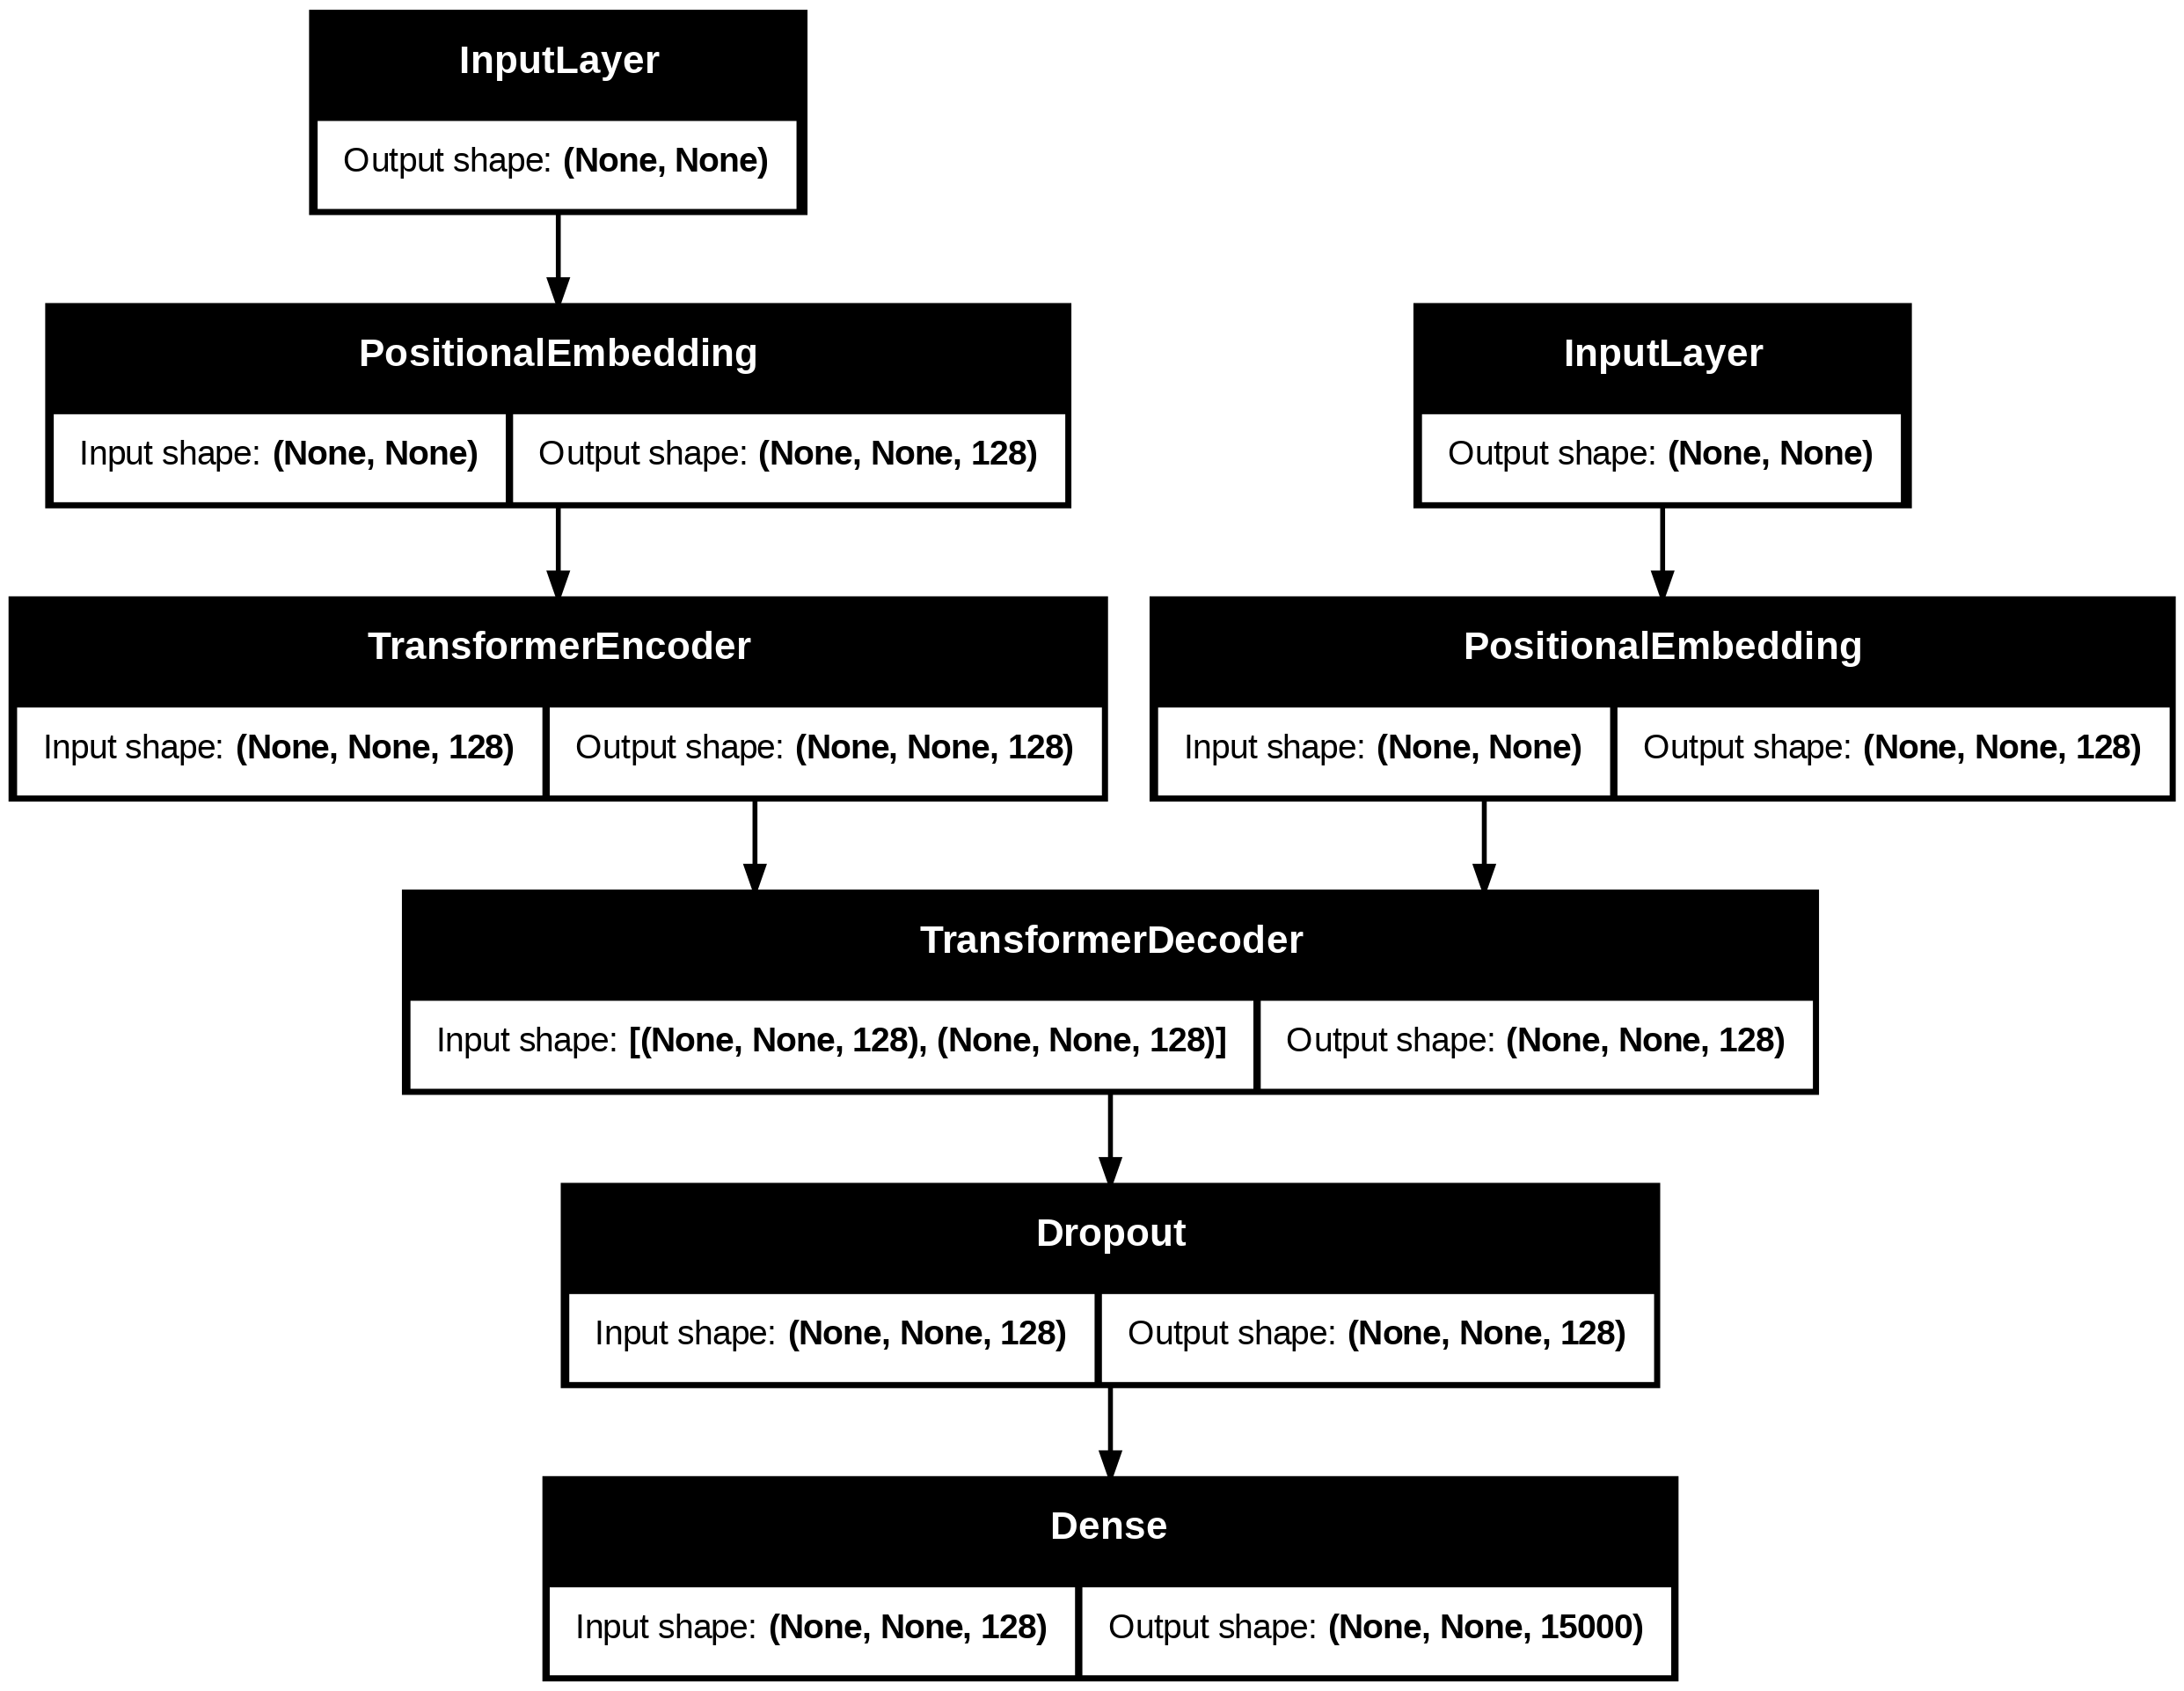

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(vanguard, to_file='vanguard.png', show_shapes=True)
from IPython.display import Image
Image("vanguard.png")

## Compile and Training

#### Transformer model

In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="language_translation_checkpoint.weights.h5",
    save_weights_only=True,
    verbose=1,
    monitor="val_accuracy"
)

transformer.fit(train_ds, epochs=5, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7104 - loss: 3.1959
Epoch 1: saving model to language_translation_checkpoint.weights.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1253s 8s/step - accuracy: 0.7106 - loss: 3.1896 - val_accuracy: 0.7716 - val_loss: 1.6012
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7737 - loss: 1.5829
Epoch 2: saving model to language_translation_checkpoint.weights.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1258s 8s/step - accuracy: 0.7737 - loss: 1.5828 - val_accuracy: 0.7785 - val_loss: 1.5094
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7800 - loss: 1.4736
Epoch 3: saving model to language_translation_checkpoint.weights.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1270s 8s/step - accuracy: 0.7800 - loss: 1.4735 - val_accuracy: 0.7829 - val_loss: 1.4524
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7840 - loss: 1.3978
Epoch 4: saving model to language_translation_checkpoint.weights.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 1295s 

#### Vanguard model

In [ ]:
vanguard.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="language_translation_checkpoint.weights.h5",
    save_weights_only=True,
    verbose=1,
    monitor="val_accuracy"
)

vanguard.fit(train_ds, epochs=5, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6960 - loss: 4.4981
Epoch 1: saving model to language_translation_checkpoint.weights.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 376s 2s/step - accuracy: 0.6963 - loss: 4.4878 - val_accuracy: 0.7667 - val_loss: 1.6719
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7688 - loss: 1.6582
Epoch 2: saving model to language_translation_checkpoint.weights.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.7688 - loss: 1.6580 - val_accuracy: 0.7759 - val_loss: 1.5622
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7760 - loss: 1.5470
Epoch 3: saving model to language_translation_checkpoint.weights.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.7760 - loss: 1.5469 - val_accuracy: 0.7784 - val_loss: 1.5056
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7806 - loss: 1.4768
Epoch 4: saving model to language_translation_checkpoint.weights.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/s

#### Training Performance Comparison
1. Initial Training (Epoch 1)
  * Transformer: train acc 71%, val acc 77%, loss is still high (3.18 → 1.60) (quite high from the start → quick adaptation).
  * Vanguard: train acc 69%, val acc 76%, higher loss (4.49 → 1.67 (start heavier than Transformer).
2. Progress Over 5 Epochs
  * Transformer: consistent increase, train acc 79.9%, val acc 81.2%, val loss decreased to 1.26.
  * Vanguard: also steadily increased, train acc 78.6%, val acc 80.2%, val loss 1.34.
  * Transformer has approximately +1% better validation accuracy and lower val loss → slightly better generalization.
3. Training Speed
  * Transformer: ± 1260 seconds/epoch (~21 minutes).
  * Vanguard: ± 370 seconds/epoch (~6 minutes).
  * Vanguard is 3x faster than Transformer.
#### Interpretation
  * Transformer is more accurate (81.2% vs. 80.2%) and has lower val loss, indicating Slightly better translation quality.
  * Vanguard is lighter, training is 3x faster, and the results are only slightly different (~1%) than Transformer.
  * If the goal is maximum accuracy (production, deployment with large servers, high-quality real-time applications) → Transformer is more appropriate.
  * If the goal is resource efficiency and speed of experimentation (prototyping, training on laptops, edge devices) → Vanguard is very practical.
  * The small performance gap indicates that Vanguard successfully maintains the trade-off between accuracy and efficiency.

## Evaluate BLEU Score

#### Transformer model

In [ ]:
# Assume test_pairs = [(eng, ind), ...]
def decode_sequence(input_sentence):
    tokenized_input = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(sequence_length):
        tokenized_target = target_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer.predict({"english": tokenized_input, "indonesian": tokenized_target}, verbose=0)
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_vectorization.get_vocabulary()[sampled_token_index]
        if sampled_token == "[end]":
            break
        decoded_sentence += " " + sampled_token
    return decoded_sentence.replace("[start] ", "")

# BLEU Evaluation
for _ in range(5):
    input_text, target_text = random.choice(test_pairs)
    prediction = decode_sequence(input_text)
    reference = [target_text.replace("[start] ", "").replace(" [end]", "").split()]
    candidate = prediction.split()
    bleu_score = sentence_bleu(reference, candidate)
    print(f"Input: {input_text}\nPrediction: {prediction}\nTarget: {reference}\nBLEU: {bleu_score:.4f}\n")

### Save Final Model
transformer.save("transformer_translation_model.keras")

Input: What do you call this animal in Japanese?
Prediction: apa yang kamu lakukan dengan apa yang kamu lakukan end          
Target: [['Apa', 'nama', 'hewan', 'ini', 'dalam', 'bahasa', 'Jepang?']]
BLEU: 0.0000

Input: It was really cheap.
Prediction: itu tidak akan terjadi end               
Target: [['Itu', 'sangat', 'murah.']]
BLEU: 0.0000

Input: My bicycle's been stolen.
Prediction: saya tidak akan pernah makan malam ini end            
Target: [['Sepedaku', 'dicuri.']]
BLEU: 0.0000

Input: Tom's parents were both teachers.
Prediction: tom tidak akan pernah makan malam ini end            
Target: [['Kedua', 'orang', 'tua', 'Tom', 'adalah', 'guru.']]
BLEU: 0.0000



/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Input: We can go some other time.
Prediction: kami tidak akan pergi ke mana end             
Target: [['Kita', 'bisa', 'pergi', 'lain', 'kali.']]
BLEU: 0.0000



#### Vanguard model

In [ ]:
# Assume test_pairs = [(eng, ind), ...]
def decode_sequence(input_sentence):
    tokenized_input = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(sequence_length):
        tokenized_target = target_vectorization([decoded_sentence])[:, :-1]
        predictions = vanguard.predict({"english": tokenized_input, "indonesian": tokenized_target}, verbose=0)
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_vectorization.get_vocabulary()[sampled_token_index]
        if sampled_token == "[end]":
            break
        decoded_sentence += " " + sampled_token
    return decoded_sentence.replace("[start] ", "")

# BLEU Evaluation
for _ in range(5):
    input_text, target_text = random.choice(test_pairs)
    prediction = decode_sequence(input_text)
    reference = [target_text.replace("[start] ", "").replace(" [end]", "").split()]
    candidate = prediction.split()
    bleu_score = sentence_bleu(reference, candidate)
    print(f"Input: {input_text}\nPrediction: {prediction}\nTarget: {reference}\nBLEU: {bleu_score:.4f}\n")

### Save Final Model
vanguard.save("vanguard_translation_model.keras")

Input: I'm sure Tom would agree with me.
Prediction: aku tidak tahu tom tidak bisa melakukannya end            
Target: [['Aku', 'yakin', 'Tom', 'akan', 'setuju', 'denganku.']]
BLEU: 0.0000

Input: You should've paid your bills on time.
Prediction: kamu tidak bisa melakukannya end               
Target: [['Kau', 'seharusnya', 'membayar', 'tagihanmu', 'tepat', 'waktu.']]
BLEU: 0.0000

Input: Can anyone drive?
Prediction: aku tidak bisa melakukannya end               
Target: [['Apakah', 'ada', 'orang', 'yang', 'bisa', 'mengemudi?']]
BLEU: 0.0000

Input: Where is the closest hospital?
Prediction: di mana kamu tidak ada di sini end            
Target: [['Di', 'mana', 'rumah', 'sakit', 'yang', 'paling', 'dekat?']]
BLEU: 0.0000

Input: Tom and Mary aren't religious at all.
Prediction: tom tidak tahu apa yang tom end             
Target: [['Tom', 'dan', 'Mary', 'tidak', 'religius', 'sama', 'sekali.']]
BLEU: 0.0000



### Saving model architecture in json file

In [ ]:
model_json = transformer.to_json()
with open("translator.json", "w") as json_file:
    json_file.write(model_json)

**Translate new sentences with Transformer model**

In [ ]:
ind_vocab = target_vectorization.get_vocabulary()
ind_index_lookup = dict(zip(range(len(ind_vocab)), ind_vocab))
max_decoded_sentence_length = 20

**Translate new sentences with vanguard model**

In [ ]:
ind_vocab = target_vectorization.get_vocabulary()
ind_index_lookup = dict(zip(range(len(ind_vocab)), ind_vocab))
max_decoded_sentence_length = 20

### Output Testing and Decoding the output sequence with transformers

In [ ]:
def transformer_decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    transformer_decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [transformer_decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ind_index_lookup[sampled_token_index]
        transformer_decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return transformer_decoded_sentence

### Output Testing and Decoding the output sequence with vanguard

In [ ]:
def vanguard_decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    vanguard_decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [vanguard_decoded_sentence])[:, :-1]
        predictions = vanguard(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ind_index_lookup[sampled_token_index]
        vanguard_decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return vanguard_decoded_sentence

### Transformer translating output

In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(transformer_decode_sequence(input_sentence))

-
I got off the bus.
[start] aku tidak akan pernah makan malam ini end            
-
The French flag is blue, white and red.
[start] rumah itu tidak ada di sini end             
-
Tom was eating.
[start] tom tidak suka dengan tom end              
-
Their birth mother abandoned them.
[start] tolong nyalakan radionya end                
-
He has an uncontrollable temper.
[start] dia tidak akan pernah makan malam ini end            


### Vanguard translating output

In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(vanguard_decode_sequence(input_sentence))

-
Tom touched Mary.
[start] tom tidak suka end                
-
I just finished breakfast.
[start] aku tidak bisa melakukannya end               
-
I have a younger sister who lives in Boston.
[start] aku tidak tahu apa yang bisa melakukannya end            
-
What are you worried about?
[start] apa kamu tidak bisa melakukannya end              
-
I wrote three letters last night.
[start] aku tidak bisa melakukannya end               


## Evaluation using the BLEU score

### Transformer BLEU Score

In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_ind_texts = [pair[1] for pair in test_pairs]
transformer_score = 0
transformer_bleu  = 0
for i in range(20):
    candidate = decode_sequence(test_eng_texts[i])
    reference = test_ind_texts[i].lower()
    print(candidate,reference)
    transformer_score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    transformer_bleu+=transformer_score
    print(f"Transformer Score:{transformer_score}")
print(f"\nTransformer BLEU score : {round(transformer_bleu,2)}/20")

aku tidak tahu apa yang kamu tidak bisa melakukannya end           [start] aku cuma ingin kamu mengingat perasaan ini. [end]
Transformer Score:0.19696969696969696
aku suka end                  [start] mari berpesta. [end]
Transformer Score:0.20689655172413796
jangan pergi end                  [start] kancingkan bajumu. [end]
Transformer Score:0.2727272727272727
tolong jangan end                  [start] bukalah kotak itu. [end]
Transformer Score:0.23529411764705885
aku tidak suka kopi end                [start] aku suka mawar merah. [end]
Transformer Score:0.23684210526315785
tom tidak tahu apa yang tom end              [start] tom menipu mary. [end]
Transformer Score:0.2727272727272727
apakah kamu suka end                 [start] tidak diragukan. [end]
Transformer Score:0.2222222222222222
tom tidak bisa melakukannya dengan hal itu end             [start] kami mengumpulkan perangko dari seluruh dunia. [end]
Transformer Score:0.25862068965517243
kamu tidak bisa melakukannya end         

In [ ]:
print(f"Transformer BLEU score : {round(transformer_bleu,2)}/20")

Transformer BLEU score : 5.2/20


### Vanguard BLEU Score

In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_ind_texts = [pair[1] for pair in test_pairs]
vanguard_score = 0
vanguard_bleu  = 0
for i in range(20):
    candidate = decode_sequence(test_eng_texts[i])
    reference = test_ind_texts[i].lower()
    print(candidate,reference)
    vanguard_score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    vanguard_bleu+=vanguard_score
    print(f"Vanguard Score:{vanguard_score}")
print(f"Vanguard BLEU score : {round(vanguard_bleu,2)}/20")

aku tidak tahu apa yang kamu tidak bisa melakukannya end           [start] aku cuma ingin kamu mengingat perasaan ini. [end]
Vanguard Score:0.19696969696969696
aku suka end                  [start] mari berpesta. [end]
Vanguard Score:0.20689655172413796
jangan pergi end                  [start] kancingkan bajumu. [end]
Vanguard Score:0.2727272727272727
tolong jangan end                  [start] bukalah kotak itu. [end]
Vanguard Score:0.23529411764705885
aku tidak suka kopi end                [start] aku suka mawar merah. [end]
Vanguard Score:0.23684210526315785
tom tidak tahu apa yang tom end              [start] tom menipu mary. [end]
Vanguard Score:0.2727272727272727
apakah kamu suka end                 [start] tidak diragukan. [end]
Vanguard Score:0.2222222222222222
tom tidak bisa melakukannya dengan hal itu end             [start] kami mengumpulkan perangko dari seluruh dunia. [end]
Vanguard Score:0.25862068965517243
kamu tidak bisa melakukannya end                [start] kamu seda

In [ ]:
print(f"Vanguard BLEU score : {round(vanguard_bleu,2)}/20")

Vanguard BLEU score : 5.2/20


### Translation

#### Translation with transformers

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

# Ambil sampel acak dari data validasi
for _ in range(5):
    input_text, target_text = random.choice(val_pairs)
    prediction = transformer_decode_sequence(input_text)

    # Format referensi dan prediksi
    reference = [target_text.replace("[start] ", "").replace(" [end]", "").split()]
    candidate = prediction.split()

    transformer_bleu = sentence_bleu(reference, candidate)

    print(f"ENGLISH   : {input_text}")
    print(f"PREDICTED : {prediction}")
    print(f"TARGET    : {' '.join(reference[0])}")
    print(f"BLEU SCORE: {transformer_bleu:.4f}\n")

ENGLISH   : Do you have any idea why Tom doesn't like Mary?
PREDICTED : [start] kamu tidak tahu apa yang tom tidak akan pergi end          
TARGET    : Apa kau tahu kenapa Tom tidak suka dengan Mary?
BLEU SCORE: 0.0000

ENGLISH   : I crouched beneath the window.
PREDICTED : [start] aku tidak akan pernah makan malam ini end            
TARGET    : Aku berjongkok di bawah jendela.
BLEU SCORE: 0.0000

ENGLISH   : Are you at home?
PREDICTED : [start] apa kamu suka dengan apa pun end             
TARGET    : Apa kamu ada di rumah?
BLEU SCORE: 0.0000

ENGLISH   : So, what do you think?
PREDICTED : [start] apa kamu tahu apa yang kamu lakukan end            
TARGET    : Jadi bagaimana menurutmu?
BLEU SCORE: 0.0000

ENGLISH   : I will take both this one and that one.
PREDICTED : [start] aku tidak tahu apa yang tidak ada yang aku tidak bisa berbahasa prancis end      
TARGET    : Aku akan mengambil baik yang ini dan yang itu.
BLEU SCORE: 0.0000



#### Translation with vanguard

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

# Ambil sampel acak dari data validasi
for _ in range(5):
    input_text, target_text = random.choice(val_pairs)
    prediction = vanguard_decode_sequence(input_text)

    # Format referensi dan prediksi
    reference = [target_text.replace("[start] ", "").replace(" [end]", "").split()]
    candidate = prediction.split()

    vanguard_bleu = sentence_bleu(reference, candidate)

    print(f"ENGLISH   : {input_text}")
    print(f"PREDICTED : {prediction}")
    print(f"TARGET    : {' '.join(reference[0])}")
    print(f"BLEU SCORE: {vanguard_bleu:.4f}\n")

ENGLISH   : These gloves belong to Tom.
PREDICTED : [start] ini tom tidak bisa melakukannya end              
TARGET    : Sarung tangan ini milik Tom.
BLEU SCORE: 0.0000

ENGLISH   : My cassette tape recorder needs fixing.
PREDICTED : [start] tolong jangan pergi ke mana end              
TARGET    : Perekam pita kasetku perlu diperbaiki.
BLEU SCORE: 0.0000

ENGLISH   : Gold is more precious than iron.
PREDICTED : [start] dia tidak bisa melakukannya end               
TARGET    : Emas lebih berharga ketimbang besi.
BLEU SCORE: 0.0000

ENGLISH   : The stamp came off.
PREDICTED : [start] itu adalah seorang yang baik end              
TARGET    : Perangkonya lepas.
BLEU SCORE: 0.0000

ENGLISH   : Let's do it.
PREDICTED : [start] aku suka end                 
TARGET    : Mari kita lakukan.
BLEU SCORE: 0.0000



In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# Prepare lists for references and candidates
references = []
candidates = []

# Loop over all sentence pairs in the test set
for input_text, target_text in test_pairs:
    prediction = transformer_decode_sequence(input_text)

    # Clear target (remove start/end tokens)
    reference = target_text.replace("[start] ", "").replace(" [end]", "").split()
    candidate = prediction.split()

    # Add to list for BLEU corpus
    references.append([reference])   # important: list of list
    candidates.append(candidate)

# Calculate the BLEU corpus
transformer_bleu_score = corpus_bleu(references, candidates)
print(f"Corpus Transformer BLEU score: {transformer_bleu_score:.4f}")

Corpus Transformer BLEU score: 0.0057


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# Prepare a list for references and candidates
references = []
candidates = []

# Loop over all sentence pairs in the test set
for input_text, target_text in test_pairs:
    prediction = vanguard_decode_sequence(input_text)

    # Clear target (remove start/end tokens)
    reference = target_text.replace("[start] ", "").replace(" [end]", "").split()
    candidate = prediction.split()

    # Add to list for BLEU corpus
    references.append([reference])   # important: list of list
    candidates.append(candidate)

# Calculate the BLEU corpus
vanguard_bleu_score = corpus_bleu(references, candidates)
print(f"Corpus Vanguard BLEU score: {vanguard_bleu_score:.4f}")

Corpus Vanguard BLEU score: 0.0031


## Evaluation Model

In [ ]:
transformer_loss, transformer_acc = transformer.evaluate(val_ds)
vanguard_loss, vanguard_acc = vanguard.evaluate(val_ds)
print("Transformer Evaluation: ")
print(f"Validation Accuracy: {transformer_acc:.4f}")
print(f"Validation Loss: {transformer_loss:.4f}")
print(f"Transformer BLEU score : {round(transformer_bleu_score,2)}/20")
print("\nVanguard Evaluation: ")
print(f"Validation Accuracy: {vanguard_acc:.4f}")
print(f"Validation Loss: {vanguard_loss:.4f}")
print(f"Vanguard BLEU score : {round(vanguard_bleu,2)}/20")

35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8075 - loss: 1.2993
35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 747ms/step - accuracy: 0.7987 - loss: 1.3702
Transformer Evaluation: 
Validation Accuracy: 0.8121
Validation Loss: 1.2692
Transformer BLEU score : 0.01/20

Vanguard Evaluation: 
Validation Accuracy: 0.8026
Validation Loss: 1.3401
Vanguard BLEU score : 0/20


In [ ]:
transformer_loss, transformer_acc = transformer.evaluate(val_ds)
vanguard_loss, vanguard_acc = vanguard.evaluate(val_ds)
print("Transformer Evaluation: ")
print(f"Validation Accuracy: {transformer_acc:.4f}")
print(f"Validation Loss: {transformer_loss:.4f}")
print(f"Corpus Transformer BLEU score : {transformer_bleu_score:.4f}")
print("\nVanguard Evaluation: ")
print(f"Validation Accuracy: {vanguard_acc:.4f}")
print(f"Validation Loss: {vanguard_loss:.4f}")
print(f"Corpus Vanguard BLEU score : {vanguard_bleu_score:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8075 - loss: 1.2993
35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 746ms/step - accuracy: 0.7987 - loss: 1.3702
Transformer Evaluation: 
Validation Accuracy: 0.8121
Validation Loss: 1.2692
Corpus Transformer BLEU score : 0.0057

Vanguard Evaluation: 
Validation Accuracy: 0.8026
Validation Loss: 1.3401
Corpus Vanguard BLEU score : 0.0031


### Interpretation
1. Accuracy and Loss
  * Transformer has a higher accuracy (81.21% vs. 80.26%) and lower loss (1.2692 vs. 1.3401).
  * This means that at the token-by-token prediction level, Transformer is more accurate at guessing the correct word than Vanguard.
2. Corpus BLEU
  * Both models have very low BLEU scores (Transformer 0.0057, Vanguard 0.0031).
  * This indicates that although individual words are often guessed correctly, the models are not yet able to construct sentences that match the ground truth.
  * Transformer still has a higher BLEU score, although the difference is small.
3. Inter-metric Concordance
  * High accuracy + very low BLEU → indicates the model can correctly guess tokens but fails to preserve word order, context, or sentence structure.
  * Transformer has a slight advantage in both accuracy and BLEU, resulting in more consistent word predictions and constructing n-grams that are more similar to the target.
4. Conclusion
  * Transformer outperforms Vanguard in all metrics (accuracy, loss, and corpus BLEU).
  * The very low BLEU scores confirm that both models are still far from achieving natural translation capabilities.
  * This evaluation demonstrates the importance of using additional metrics (such as BLEU) beyond accuracy, as text quality is not only about the correctness of tokens, but also how sentences are structured to match the target language.

# Conclusion
The evaluation results show that Transformer has advantages in accuracy and loss, indicating better token prediction accuracy than Vanguard. However, the relatively low Corpus BLEU scores for both models indicate that sentence structure is still far from ideal, even though word-by-word prediction is quite accurate. This means that the syntactic and semantic quality of the sentences are not fully maintained. This situation emphasizes that accuracy and BLEU should not be viewed in isolation, but rather complement each other: accuracy for assessing token prediction, and BLEU for assessing sentence fluency. With improved decoding strategies (e.g., beam search) and more sophisticated fine-tuning, BLEU scores can be improved, bringing Transformer closer to its potential as a foundation for modern generative language models.

# Thank You